# Plots for paper

For reference
https://docs.juliaplots.org/latest/

In [4]:
using Plots, DelimitedFiles

## Default plot settings

In [5]:
# pyplot();
gr(); # default backend. Can use `pyplot()` instead

In [6]:
Plots.default(
    grid = false,
    size = (400,400),
    fontfamily="sans-serif",     # "serif-roman" is the closest thing to latex i could find
    markerstrokewidth = 1,        # border around dots
    markersize = 3
)

To inspect some plot attribute, use `plotattr`:

In [7]:
Plots.plotattr("grid")

grid {Bool, Symbol, String or `nothing`}
grids

Show the grid lines? `true`, `false`, `:show`, `:hide`, `:yes`, `:no`, `:x`, `:y`, `:z`, `:xy`, ..., `:all`, `:none`, `:off`
Axis attribute,  default: true


### Saving plots
Saving plots to PDF instead of image formats uses vector graphic format => good for zooming in and out without losing quality
`savefig("dir/filename.pdf")`

### Functions

In [8]:
# plot a blank rate-distortion plane
function plot_rdb(; 
        f30=true,   # RS curve with f3=0 
        f3=false    # RS curve with f3!=0
        ) 
    DD = 0.0001:0.001:0.5
    RR = 1 .+ DD.*log2.(DD) + (1 .- DD).*log2.(1 .- DD)
    pl = Plots.plot(RR, DD, label="Rate-Information bound")
    Plots.plot!(pl, RR, 0.5*(1 .- RR), label="Naive compression")
    if f30
        # RS curve for f3=0 : variables have degree 1 or 2
        R_f30 = 0.01:0.01:0.99
        D_f30 = [0.4546474073128681,0.43565049932361133,0.42092765046912317,0.40839439222208573,0.3972457420215144,0.3870702443196218,0.3776242651788484,0.36874955806591975,0.3603365352601175,0.3523056385673838,0.34459697668198624,0.33716414626734653,0.3299703418625086,0.3229857971761951,0.31618604029437997,0.30955066735206993,0.30306245811343413,0.2967067238049428,0.2904708168067388,0.2843437556958753,0.2783159341345032,0.27237889177802405,0.26652513178257226,0.2607479738209666,0.2550414345013817,0.24940012917780852,0.2438191906350483,0.2382942012118009,0.2328211357178961,0.22739631308980668,0.22201635516998064,0.21667815133009227,0.211378827914124,0.20688352899753953,0.20278317659003975,0.19868817793711935,0.1945975994415784,0.19051056552023182,0.18642625421128822,0.18234389327612,0.17826275673045133,0.17418216174918932,0.17010146589683228,0.16602006464188257,0.16193738911916555,0.15785290410864755,0.1537661062033548,0.14967652214243293,0.1455837072883871,0.14148724423013948,0.137998366107847,0.13448740638286893,0.13095421069018287,0.12739865696194796,0.12382065470933767,0.12022014422138577,0.11659709568295457,0.1129515082152911,0.10928340884389087,0.10559285139949881,0.10231362606715677,0.0989986151678956,0.09564794614910743,0.0922617930523803,0.0888403753926773,0.08538395674018595,0.0820151560863665,0.0788488704133426,0.07563678673548502,0.07237911796887381,0.06907615625262697,0.06591319349557895,0.06283584277258297,0.05970319879491964,0.056515457092013055,0.053562785457060835,0.05054512262289507,0.04752198628196386,0.04463641809759822,0.04167585667427448,0.0388827836051418,0.03604608454052277,0.033304960430999175,0.03060809220840449,0.027952952887639493,0.025359146185103376,0.022832861932172044,0.020370784947590925,0.017979055383501308,0.015666129177374533,0.013449978144655372,0.0113201258591068,0.009302254807509736,0.007397829094439923,0.0056264302423451595,0.004010648891537405,0.002577264143732827,0.0013672330158682189,0.0004509986577261871]
        plot!(pl, R_f30, D_f30, lc=:gray, ls=:dash, 
            label="RS degree 2")
    end
    if f3
        # RS curve for degree-3 factors and varying portion of degree-3 variables
        R_f3 = [0.33333333333333337,0.33000000000000007,0.32666666666666666,0.32333333333333336,0.31999999999999995,0.31666666666666676,0.31333333333333335,0.31000000000000005,0.30666666666666664,0.30333333333333334,0.29999999999999993,0.29666666666666675,0.29333333333333333,0.29000000000000004,0.2866666666666666,0.2833333333333333,0.2799999999999999,0.2766666666666667,0.2733333333333333,0.2699999999999999,0.2666666666666666,0.2633333333333333,0.2599999999999999,0.2566666666666667,0.2533333333333333,0.25,0.2466666666666667,0.2433333333333333,0.23999999999999988,0.2366666666666667,0.2333333333333334,0.2300000000000001,0.22666666666666668,0.22333333333333327,0.22000000000000008,0.21666666666666679,0.21333333333333326,0.20999999999999996,0.20666666666666667,0.20333333333333348,0.19999999999999984,0.19666666666666666,0.19333333333333336,0.18999999999999995,0.18666666666666654,0.18333333333333324,0.18000000000000005,0.17666666666666675,0.17333333333333334,0.16999999999999993,0.16666666666666663,0.16333333333333344,0.16000000000000003,0.15666666666666662,0.15333333333333332,0.15000000000000002,0.1466666666666666,0.1433333333333332,0.14,0.13666666666666671,0.13333333333333341,0.1299999999999999,0.1266666666666666,0.1233333333333334,0.1200000000000001,0.11666666666666659,0.11333333333333329,0.10999999999999999,0.1066666666666668,0.10333333333333339,0.10000000000000009,0.09666666666666668,0.09333333333333327,0.08999999999999997,0.08666666666666678,0.08333333333333337,0.07999999999999996,0.07666666666666666,0.07333333333333336,0.06999999999999995,0.06666666666666654,0.06333333333333335,0.05999999999999994,0.05666666666666664,0.053333333333333344,0.050000000000000155,0.04666666666666652,0.043333333333333335,0.040000000000000036,0.036666666666666736,0.033333333333333215,0.029999999999999916,0.026666666666666727,0.023333333333333428,0.020000000000000018,0.01666666666666672,0.013333333333333308,0.009999999999999898,0.00666666666666671,0.0033333333333334103,0.0]
        D_f3 = [0.20962056095628745,0.21045655312219785,0.21129398045076497,0.21213285191160997,0.21297317651789593,0.213814963331392,0.21465822146743357,0.21550296009981335,0.21634918846557782,0.2171969158697719,0.21804615169011754,0.2188969053816388,0.21974918648125297,0.22060300461230448,0.22145836948909192,0.22231529092135494,0.22317377881874867,0.22403384319531316,0.22489549417392346,0.22575874199075563,0.2266235969997512,0.22749006967709307,0.22835817062570685,0.22922791057977476,0.23009930040929016,0.23097235112463632,0.23184707388120812,0.23272347998408488,0.2336015808927387,0.23448138822581466,0.2353629137659588,0.23624616946472055,0.23713116744752138,0.23801792001870203,0.23890643966665281,0.2397967390690277,0.2406888310980555,0.24158272882594994,0.24247844553042286,0.2433759947003037,0.24427539004128584,0.24517664548178786,0.2460797751789402,0.24698479352472213,0.2478917151522217,0.248800554942059,0.2497113280289589,0.2506240498084894,0.2515387359439647,0.2524554023735355,0.25337406531746137,0.25429474128557106,0.25521744708493777,0.2561421998277597,0.2570690169394544,0.25799791616700474,0.2589289155875188,0.2598620336170625,0.26079728901973587,0.2617347009170402,0.26267428879751364,0.26361607252667024,0.2645600723572469,0.26550630893977045,0.2664548033334655,0.26740557701750556,0.26835865190263664,0.2693140503431725,0.2702717951493969,0.271231909600374,0.2721944174571924,0.27315934297666117,0.27412671092547497,0.2750965465948728,0.2760688758158149,0.2770437249746786,0.2780211210295341,0.27900109152699526,0.2799836646196798,0.28096886908431673,0.28195673434051494,0.28294729047022854,0.283940568237963,0.2849365991117401,0.2859354152848619,0.28693704969851397,0.28794153606524925,0.2889489088934002,0.28995920351242044,0.290972456099293,0.2919887037059378,0.2930079842877797,0.29403033673345685,0.2950558008957639,0.2960844176238681,0.29711622879689686,0.298151277358935,0.2991896073555008,0.30023126397162553,0.30127629357155217,0.30232474374018364]
        plot!(pl, R_f3, D_f3, label="RS RS degree 2 and 3", lc=:magenta)
    end
    xlabel!(pl, "R"); ylabel!(pl, "D")
    pl
end

plot_rdb (generic function with 1 method)

## 1. RS, MaxSum, Exact algo

In [9]:
D_exact_avg = vec([0.31919444444444445
 0.28608333333333336
 0.2564444444444445
 0.22800000000000004
 0.20480555555555555
 0.18383333333333332
 0.16325
 0.14291666666666664
 0.12613888888888888
 0.1078888888888889
 0.09316666666666666
 0.07852777777777778])
D_ms_avg =vec([ 0.32355555555555554
 0.2872777777777778
 0.2599444444444444
 0.23180555555555554
 0.20811111111111108
 0.18577777777777776
 0.16783333333333333
 0.14408333333333334
 0.12827777777777777
 0.11052777777777775
 0.09483333333333333
 0.07922222222222224])
Rs = 0.15:0.05:0.7
R_rs = 0.01:0.01:0.99
D_rs = [0.4546474073128681,0.43565049932361133,0.42092765046912317,0.40839439222208573,0.3972457420215144,0.3870702443196218,0.3776242651788484,0.36874955806591975,0.3603365352601175,0.3523056385673838,0.34459697668198624,0.33716414626734653,0.3299703418625086,0.3229857971761951,0.31618604029437997,0.30955066735206993,0.30306245811343413,0.2967067238049428,0.2904708168067388,0.2843437556958753,0.2783159341345032,0.27237889177802405,0.26652513178257226,0.2607479738209666,0.2550414345013817,0.24940012917780852,0.2438191906350483,0.2382942012118009,0.2328211357178961,0.22739631308980668,0.22201635516998064,0.21667815133009227,0.211378827914124,0.20688352899753953,0.20278317659003975,0.19868817793711935,0.1945975994415784,0.19051056552023182,0.18642625421128822,0.18234389327612,0.17826275673045133,0.17418216174918932,0.17010146589683228,0.16602006464188257,0.16193738911916555,0.15785290410864755,0.1537661062033548,0.14967652214243293,0.1455837072883871,0.14148724423013948,0.137998366107847,0.13448740638286893,0.13095421069018287,0.12739865696194796,0.12382065470933767,0.12022014422138577,0.11659709568295457,0.1129515082152911,0.10928340884389087,0.10559285139949881,0.10231362606715677,0.0989986151678956,0.09564794614910743,0.0922617930523803,0.0888403753926773,0.08538395674018595,0.0820151560863665,0.0788488704133426,0.07563678673548502,0.07237911796887381,0.06907615625262697,0.06591319349557895,0.06283584277258297,0.05970319879491964,0.056515457092013055,0.053562785457060835,0.05054512262289507,0.04752198628196386,0.04463641809759822,0.04167585667427448,0.0388827836051418,0.03604608454052277,0.033304960430999175,0.03060809220840449,0.027952952887639493,0.025359146185103376,0.022832861932172044,0.020370784947590925,0.017979055383501308,0.015666129177374533,0.013449978144655372,0.0113201258591068,0.009302254807509736,0.007397829094439923,0.0056264302423451595,0.004010648891537405,0.002577264143732827,0.0013672330158682189,0.0004509986577261871];

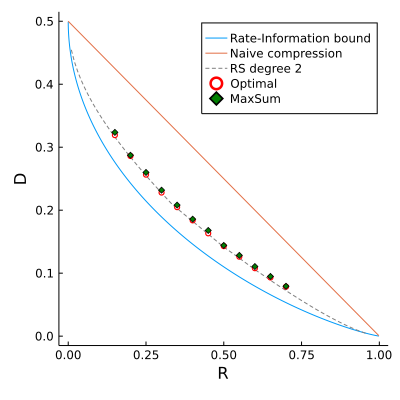

In [10]:
pl1 = plot_rdb(; f30=false, f3=false)
plot!(pl1, R_rs[1:end-3], D_rs[1:end-3], label="RS degree 2", line=:dash, c=:gray)
scatter!(pl1, Rs, D_exact_avg, label="Optimal", m=:circle, c=:white, msc=:red, msw=1.5)
scatter!(pl1, Rs, D_ms_avg, label="MaxSum", c=:green, m=:diamond)
plot!(pl1, size=(400,400))

In [11]:
savefig("rdb_degree2.pdf")

# 2. BP + decimation

## 2.1 with $f_1=0.01$

In [12]:
# cavity prediction for degree profile (f1=0.01,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at y=0.5
Rs_rsb_23_f1, Ds_rsb_23_f1, Ds_er_rsb_23_f1 = (0.11:0.02:0.33, [0.29777805377902944, 0.29683887037479406, 0.29582385951300305, 0.2948347137869458, 0.2939791979198608, 0.25053478549223196, 0.2416864748805047, 0.2339751669822056, 0.22710152487798052, 0.2212325303057276, 0.21572902652590437, 0.21062467103921972], [0.00012441371933976755, 9.435541130087328e-5, 0.000141601887435988, 0.00011094506703840518, 0.0001563712398488542, 0.00014246941922547608, 0.0002234457277189683, 0.00027012546822589894, 0.0002966507259901999, 0.00026985258779472934, 0.0003962648264896767, 0.0004420123030401369])

(0.11:0.02:0.33, [0.29777805377902944, 0.29683887037479406, 0.29582385951300305, 0.2948347137869458, 0.2939791979198608, 0.25053478549223196, 0.2416864748805047, 0.2339751669822056, 0.22710152487798052, 0.2212325303057276, 0.21572902652590437, 0.21062467103921972], [0.00012441371933976755, 9.435541130087328e-5, 0.000141601887435988, 0.00011094506703840518, 0.0001563712398488542, 0.00014246941922547608, 0.0002234457277189683, 0.00027012546822589894, 0.0002966507259901999, 0.00026985258779472934, 0.0003962648264896767, 0.0004420123030401369])

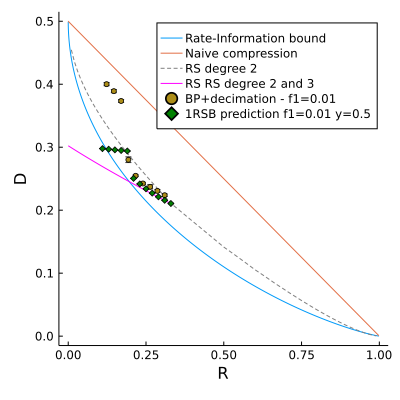

In [13]:
M = readdlm("bp_dec.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
pl2 = plot_rdb(; f3=true)
scatter!(pl2, R_bp_dec, D_bp_dec_avg, label="BP+decimation - f1=0.01", ms=3, yerr=D_bp_dec_std)
scatter!(pl2, Rs_rsb_23_f1, Ds_rsb_23_f1, yerr=Ds_er_rsb_23_f1, label="1RSB prediction f1=0.01 y=0.5", 
    c=:green, m=:diamond)

## 2.2 with zero leaves 

In [14]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [15]:
# cavity prediction for degree profile (f1,f2,f3) with f1=0.01 for variables, (0,0,1) for factors
# obtained with energetic method at y=0.5
Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = (0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])

(0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])

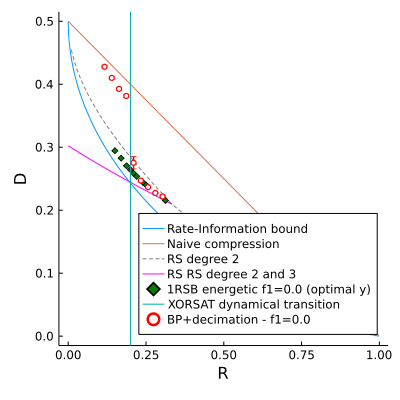

In [16]:
M = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
pl2 = plot_rdb(; f3=true)
scatter!(pl2, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="1RSB energetic f1=0.0 (optimal y)", 
    c=:green, m=:diamond)
vline!(pl2, [0.2], label="XORSAT dynamical transition")
#scatter!(pl2, Rs_ent, dist_ent, yerr=std_dist_ent[1:end-1], label="1RSB entropic f1=0.0 (at β_d)", 
#    c=:blue, m=:diamond)
scatter!(pl2, R_bp_dec, D_bp_dec_avg, label="BP+decimation - f1=0.0", yerr=D_bp_dec_std, 
    m=:circle, c=:white, msc=:red, msw=1.5, legend=:bottomright)


In [17]:
savefig(pl2, "bp_dec_zeroleaves.pdf")

## 3. MS + reinforcement

## 3.1 with $f_1=0.01$ 

In [18]:
Rs_rsb_23_f1, Ds_rsb_23_f1, Ds_er_rsb_23_f1 = (0.11:0.02:0.33, [0.29777805377902944, 0.29683887037479406, 0.29582385951300305, 0.2948347137869458, 0.2939791979198608, 0.25053478549223196, 0.2416864748805047, 0.2339751669822056, 0.22710152487798052, 0.2212325303057276, 0.21572902652590437, 0.21062467103921972], [0.00012441371933976755, 9.435541130087328e-5, 0.000141601887435988, 0.00011094506703840518, 0.0001563712398488542, 0.00014246941922547608, 0.0002234457277189683, 0.00027012546822589894, 0.0002966507259901999, 0.00026985258779472934, 0.0003962648264896767, 0.0004420123030401369])

(0.11:0.02:0.33, [0.29777805377902944, 0.29683887037479406, 0.29582385951300305, 0.2948347137869458, 0.2939791979198608, 0.25053478549223196, 0.2416864748805047, 0.2339751669822056, 0.22710152487798052, 0.2212325303057276, 0.21572902652590437, 0.21062467103921972], [0.00012441371933976755, 9.435541130087328e-5, 0.000141601887435988, 0.00011094506703840518, 0.0001563712398488542, 0.00014246941922547608, 0.0002234457277189683, 0.00027012546822589894, 0.0002966507259901999, 0.00026985258779472934, 0.0003962648264896767, 0.0004420123030401369])

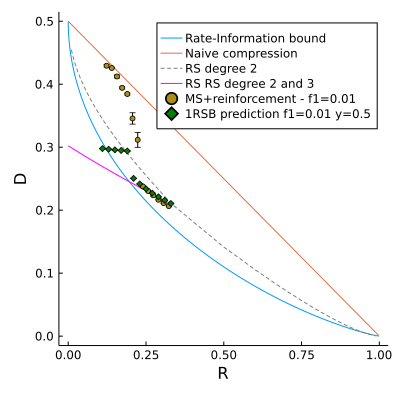

In [19]:
M = readdlm("ms_rein.txt")
R = M[:,1]
D_avg = M[:,2]
D_std = M[:,3]
pl2 = plot_rdb(; f3=true)
scatter!(pl2, R, D_avg, label="MS+reinforcement - f1=0.01", yerr=D_std)
scatter!(pl2, Rs_rsb_23_f1, Ds_rsb_23_f1, yerr=Ds_er_rsb_23_f1, label="1RSB prediction f1=0.01 y=0.5", 
    c=:green, m=:diamond)

In [20]:
savefig(pl2, "ms_rein.pdf")

## 3.2 with zero leaves 

In [21]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [22]:
Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = (0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])

(0.11:0.02:0.33, [0.2977365737135704, 0.29679166785456546, 0.29575210731434554, 0.2949943231803669, 0.29397756485409976, 0.2501368753571527, 0.2411632189267363, 0.23388637157790765, 0.22714230559385223, 0.22128279206129292, 0.21565456260060245, 0.21012801774847617], [9.010253981269411e-5, 0.00018398776528276, 8.403118148946889e-5, 0.00015897456190779003, 9.16495914260236e-5, 0.0001709187426321453, 0.00017466109542782523, 0.000173980573936482, 0.0002413785375950678, 0.0003529835098745958, 0.00027606828090559466, 0.0004617280214407081])

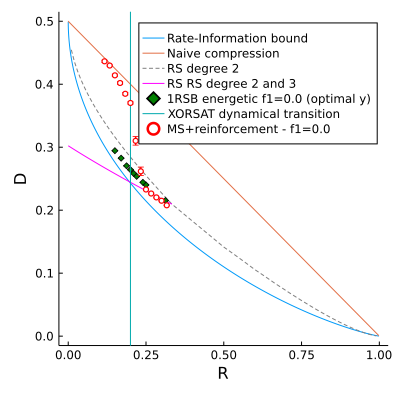

In [23]:
M = readdlm("ms_rein_zeroleaves.txt")
R_ms_0 = M[:,1]
D_ms_0_avg = M[:,2]
D_ms_0_std = M[:,3]
pl2 = plot_rdb(; f3=true)
scatter!(pl2, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="1RSB energetic f1=0.0 (optimal y)", 
    c=:green, m=:diamond)
vline!(pl2, [0.2], label="XORSAT dynamical transition")
scatter!(pl2, R_ms_0, D_ms_0_avg, label="MS+reinforcement - f1=0.0", yerr=D_ms_0_std, 
    m=:circle, c=:white, msc=:red, msw=1.5)


In [24]:
savefig(pl2, "ms_rein_zeroleaves.pdf")

# 3'. Compare BP and MS

In [25]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [26]:
M = readdlm("ms_rein_zeroleaves.txt")
R_ms_0 = M[:,1]
D_ms_0_avg = M[:,2]
D_ms_0_std = M[:,3];

In [27]:
B = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = B[:,1]
D_bp_dec_avg = B[:,2]
D_bp_dec_std = B[:,3];

┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873


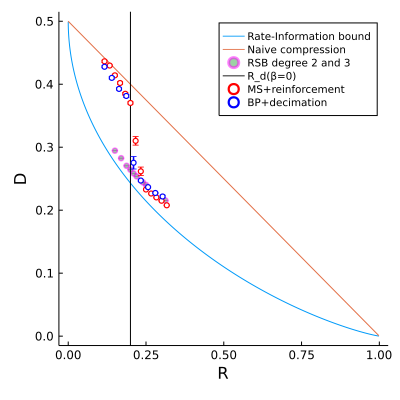

In [28]:
pl3 = plot_rdb(; f3=false, f30=false)
scatter!(pl3, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="RSB degree 2 and 3", m=:à, msc=:magenta, markeralpha=0.5, msw=2)
vline!(pl3, [0.2], label="R_d(β=0)", lc=:black)
scatter!(pl3, R_ms_0, D_ms_0_avg, label="MS+reinforcement", yerr=D_ms_0_std, 
    m=:circle, c=:white, msc=:red, msw=1.5)
scatter!(pl3, R_bp_dec, D_bp_dec_avg, label="BP+decimation", yerr=D_bp_dec_std, 
    m=:circle, c=:white, msc=:blue, msw=1.5, legend=:topright, legendfontsize=7)


In [29]:
savefig(pl3, "BPMS_zeroleaves.pdf")

# 4. Compare BP and SP

In [30]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [31]:
results_bp = readdlm("bp_dec.txt")
results_bp = [collect(c) for c in eachcol(results_bp)]
R_bp, D_bp_avg, D_bp_std = results_bp

results_sp = readdlm("sp_dec.txt")
results_sp = [collect(c) for c in eachcol(results_sp)]
R_sp, D_sp_avg, D_sp_std = results_sp;

In [32]:
R_bp, R_sp

([0.12333333333333334, 0.14666666666666667, 0.17, 0.19333333333333333, 0.21666666666666667, 0.24, 0.2633333333333333, 0.2866666666666667, 0.31], [0.11666666666666665, 0.13333333333333333, 0.15, 0.16666666666666666, 0.18333333333333335, 0.19999999999999998, 0.21666666666666667, 0.2333333333333333, 0.25, 0.26666666666666666, 0.2833333333333333, 0.3, 0.31666666666666665])

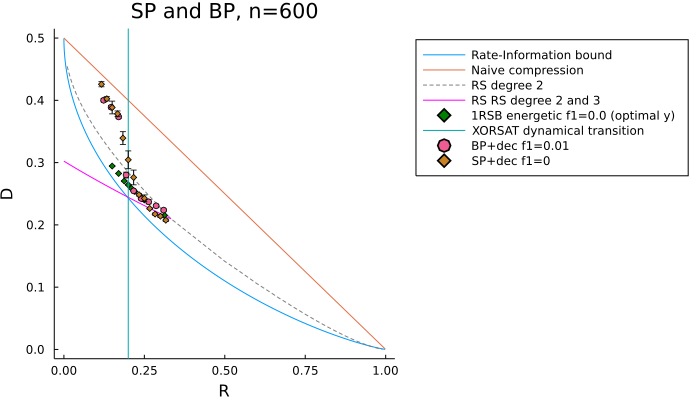

In [33]:
Plots.gr(grid=false)
pp = plot_rdb(; f3=true)
scatter!(pp, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="1RSB energetic f1=0.0 (optimal y)", 
    c=:green, m=:diamond)
vline!(pp, [0.2], label="XORSAT dynamical transition")
scatter!(pp, R_bp, D_bp_avg, yerr=D_bp_std, label="BP+dec f1=0.01",m=:o)
scatter!(pp, R_sp, D_sp_avg, yerr=D_sp_std, label="SP+dec f1=0", m=:diamond)
#scatter!(pp, Rs_rsb_23, Ds_rsb_23, yerr=Ds_er_rsb_23, label="1RSB prediction f1=0.0 y=0.5",m=:o, color="magenta")
plot(pp, size=(700,400), legend=:outertopright, legendfontsize=8, title="SP and BP, n=600")

In [34]:
savefig("sp_vs_bp.pdf")

# 5. Effect of leaves

## 5.1 scanning whole rate range, RS results

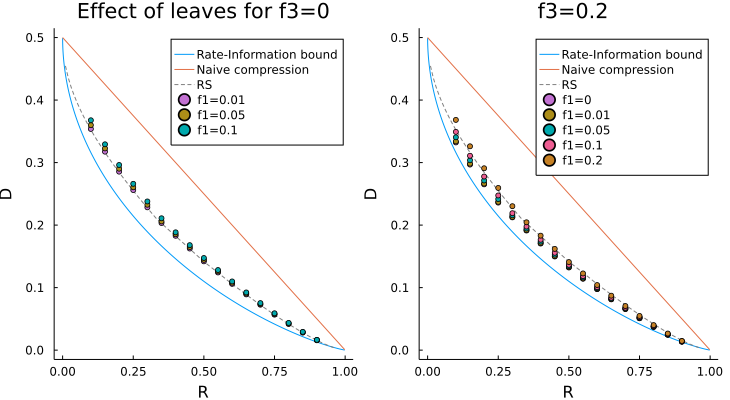

In [35]:
# rate range
Rs = 0.1:0.05:0.9
# RS results for f3=0.0
Ds_f3_0_f1_0p01, Ds_f3_0_f1_0p05, Ds_f3_0_f1_0p1 = ([0.3538114335524735, 0.31747333967605695, 0.28550746383060205, 0.25612515129784885, 0.2284243225569061, 0.2033910893533976, 0.18293878887331982, 0.1625208876163704, 0.14206038429971335, 0.12423890401296722, 0.10601020204619749, 0.08917422047446771, 0.0726572368732713, 0.05675467289922209, 0.04185916012542079, 0.028071855229167386, 0.01574301318073207], [0.3599050776211877, 0.3226648453721803, 0.29019771926622145, 0.26049291716292117, 0.2325676263308195, 0.20585409643346214, 0.1853483508080932, 0.1648831563182369, 0.14437930945731164, 0.12593631741846584, 0.10770129914173976, 0.09052816465343305, 0.07378510636970143, 0.05772389823369306, 0.042601552543997, 0.028553449188991664, 0.016053768588757344], [0.3676615378640236, 0.32923394778628684, 0.2961315813635285, 0.26602272854364084, 0.23781629974845775, 0.21089708040441102, 0.18843309796056706, 0.16790485268492794, 0.147342288518024, 0.12811897166687308, 0.10986913936893428, 0.09226722031249313, 0.07523381695394232, 0.05896673383103934, 0.04355297456833068, 0.029247162806274096, 0.016450739330244213])
# RS results for f3=0.2
Ds_f3_0p2_f1_0, Ds_f3_0p2_f1_0p01, Ds_f3_0p2_f1_0p05, Ds_f3_0p2_f1_0p1, Ds_f3_0p2_f1_0p2 = ([0.3322627067197179, 0.29682399799636033, 0.2652142088206533, 0.23598355719628716, 0.2123830924811329, 0.19132403903558443, 0.17050021867056409, 0.1498022877065564, 0.13222941966534785, 0.11424686011065444, 0.09757224370918316, 0.08124027127198608, 0.06571339439818585, 0.050953896712127966, 0.03715166075775189, 0.024613021387468015, 0.01357274246883805], [0.333868728700506, 0.29818278170700563, 0.2664259235150219, 0.23709728373885547, 0.2130269482256809, 0.19193995453878154, 0.17109319413932034, 0.15037617186543734, 0.13263241498621114, 0.11464474651336476, 0.09787900655565385, 0.08148719150488887, 0.06591981642798589, 0.051133583563305884, 0.03729033457189129, 0.02470274660127031, 0.01362641921497737], [0.34046142037569005, 0.30371828129640227, 0.2713457654925405, 0.24161036405482117, 0.21564485314223159, 0.1944414944643571, 0.17349859452772148, 0.15270114103656424, 0.13426965456172124, 0.11625717081244002, 0.09912258601333906, 0.08248740306472102, 0.06675452971467677, 0.05185844712617971, 0.037848550646467416, 0.025063005272762395, 0.013841101331753702], [0.3491215306658214, 0.3108741142211763, 0.2776659089288807, 0.24738820827697222, 0.2190204644069924, 0.1976609611191985, 0.17658745822970517, 0.15567963371147514, 0.13637985626129517, 0.11832517261131326, 0.10071918166584576, 0.08376990259676081, 0.06782131267780589, 0.05278048608206459, 0.038555727258582806, 0.025517291981177748, 0.014109849693690224], [0.3682671109506991, 0.3260508990087317, 0.2909095932703236, 0.259432464382357, 0.23023328559154782, 0.20446353196179334, 0.18308998363377182, 0.16192358241677962, 0.14086579157263457, 0.12267887795348192, 0.1040915899601772, 0.08709894412612307, 0.07053348757061617, 0.05469506958873682, 0.040013130941424335, 0.026581797868652002, 0.014713650156026492])


pl51 = plot_rdb(; f30=false, f3=false)
plot!(pl51, R_rs[1:end-3], D_rs[1:end-3], label="RS", line=:dash, c=:gray)
scatter!(pl51, Rs,Ds_f3_0_f1_0p01, label="f1=0.01", ms=3)
scatter!(pl51, Rs,Ds_f3_0_f1_0p05, label="f1=0.05", ms=3)
scatter!(pl51, Rs,Ds_f3_0_f1_0p1, label="f1=0.1", ms=3)
#plot!(pl41, size=(400,400))

pl52 = plot_rdb(; f30=false, f3=false)
plot!(pl52, R_rs[1:end-3], D_rs[1:end-3], label="RS", line=:dash, c=:gray)
scatter!(pl52, Rs,Ds_f3_0p2_f1_0, label="f1=0", ms=3)
scatter!(pl52, Rs,Ds_f3_0p2_f1_0p01, label="f1=0.01", ms=3)
scatter!(pl52, Rs,Ds_f3_0p2_f1_0p05, label="f1=0.05", ms=3)
scatter!(pl52, Rs,Ds_f3_0p2_f1_0p1, label="f1=0.1", ms=3)
scatter!(pl52, Rs,Ds_f3_0p2_f1_0p2, label="f1=0.2", ms=3)
#plot!(pl42, size=(400,400))

pl5 = plot(pl51, pl52, size=(730,400), title=["Effect of leaves for f3=0" " f3=0.2"])

In [36]:
savefig(pl5, "effect-leaves-rs-results.pdf")

## 5.2 Looking at R=0.5, f3=0.2 

In [37]:
# load maxsum points
M = readdlm("ms_rein_leaves.txt")
D_ms_avg = M[:,2]
D_ms_std = M[:,3];

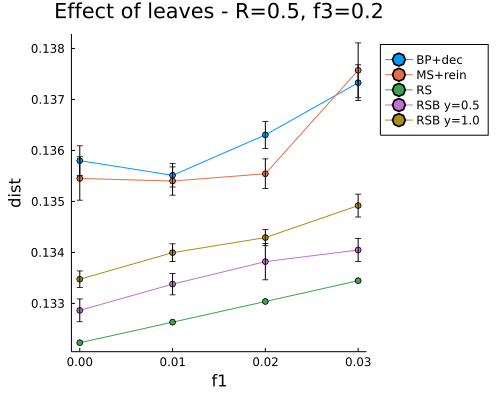

In [38]:
R = 0.5
f3 = 0.2
f1s = [0, 0.01, 0.02, 0.03]

# D_bp_avg = [0.13694, 0.13586666666666666, 0.1368095238095238, 0.1382]
# D_bp_avg = [0.13626000000000002, 0.13546666666666668, 0.13627619047619047, 0.13797142857142858]
D_bp_avg = [0.1358, 0.13551190476190478, 0.1363047619047619, 0.13732857142857144]
# D_bp_std = [0.0006895192054568723, 0.0004977509694426526, 0.00040753920546258954, 0.000982826292823859]
# D_bp_std = [0.0003329148888714999, 0.0003222922321743141, 0.0002442569697685512, 0.0004692920232564644]
D_bp_std = [0.0002911595255984828, 0.00022888223414870042, 0.00026487880479648626, 0.00035128870386219867]
# D_ms_avg = [0.13689, 0.13547619047619047, 0.1361904761904762, 0.13677142857142857]
# D_ms_avg = [ 0.13592, 0.13590476190476192, 0.13543333333333335, 0.13715714285714287]
# D_ms_std = [0.0004919339283877355, 0.0003267402668746189, 0.00029040560887963403, 0.000620085709691354]
# D_ms_std = [0.0004232343000363659, 0.000268351715927465, 0.0002988096435805359, 0.000569077051893281]
D_rs = [0.13222941966534785, 0.13263241498621114, 0.13303785226752174, 0.13344581372769876]
D_rsb_05_avg, D_rsb_05_std = ([0.13286383005200447, 0.13337822683241052, 0.13381980858732828, 0.13404746134233042],
                        [0.00022356049611805284, 0.00021024886520088962, 0.0003570168150122643, 0.00022440999928071992])
D_rsb_10_avg, D_rsb_10_std = ([0.13347426622816017, 0.13399613161612411, 0.13429123049249525, 0.13491873144650474], 
                        [0.00016241445530150252, 0.0001725802572197361, 0.00015959020090432725, 0.00022412171971524])
pp = plot(f1s, D_bp_avg, xlabel="f1", ylabel="dist", size=(300,300), yerr=D_bp_std, m=:o, label="BP+dec")
plot!(pp, f1s, D_ms_avg, xlabel="f1", ylabel="dist", size=(300,300), yerr=D_ms_std,m=:o, label="MS+rein")
plot!(pp, f1s, D_rs, m=:o,label="RS")
plot!(pp, f1s, D_rsb_05_avg, label="RSB y=0.5", legend=:outertopright,m=:o, yerr=D_rsb_05_std)
plot!(pp, f1s, D_rsb_10_avg, label="RSB y=1.0", legend=:outertopright,m=:o, yerr=D_rsb_10_std)
plot(pp, size=(500,400), title="Effect of leaves - R=$R, f3=$f3")

In [39]:
savefig(pp, "effect-leaves-cavity-algos.pdf")

# 6. RS and RSB predictions for $\Lambda(x)=f_1x+f_2x^2+f_3x^3$ and $P(x)=x^3$

## 6.1 Study at fixed $y=0.5$ 

In [40]:
# RS results for mix of deg 1 and 2 variables
R12, D12 = ([0.3333333333333333, 0.35333333333333333, 0.37333333333333335, 0.3933333333333333, 0.41333333333333333, 0.43333333333333335, 0.4533333333333333, 0.47333333333333333, 0.49333333333333335, 0.5133333333333333, 0.5333333333333333, 0.5533333333333333, 0.5733333333333334, 0.5933333333333334, 0.6133333333333333, 0.6333333333333333, 0.6533333333333333], [0.20962056095628745, 0.20510675972527204, 0.2006681095706887, 0.1963150986467942, 0.19206044986217263, 0.18791975969258612, 0.18391237135471517, 0.18006258976893397, 0.17640140622720218, 0.17296900253649872, 0.16981848174327074, 0.16702159326400678, 0.1646778261813926, 0.16292944871509907, 0.16198761138123774, 0.16218037482422176, 0.1640476353615466])
#RSB results: with J=20, y=0.5, popsize=10^6, maxiter=2*10^3, samples=10^8
# RSB results for mix of deg 1 and 2 variables, at y=0.5
Rs_rsb_12, Ds_rsb_12, Ds_er_rsb_12 = ([0.6666666666666667, 0.6333333333333333, 0.5999999999999999, 0.5666666666666667, 0.5333333333333334, 0.5, 0.4666666666666667, 0.43333333333333335, 0.4, 0.3666666666666667, 0.33333333333333337], [0.16650789649221948, 0.1619545698930388, 0.16254724608761323, 0.16540297668402337, 0.16983330668483132, 0.17531828954432616, 0.18126193781344913, 0.18797821686621807, 0.19515535726021943, 0.20209784064401598, 0.20965424141256622], [0.0003119215398973763, 0.00027977043094751036, 0.00029872535597937424, 0.00036559228419771243, 0.0003166580587697831, 0.0004597198308554774, 0.00031230872288686465, 0.00036419831799057846, 0.00044620878219726824, 0.00031767804611598603, 0.0005155641070213254])
# RSB results for mix of deg 2 and 3 variables, at y=0.5
Rs_rsb_23, Ds_rsb_23, Ds_er_rsb_23 = ([0.0, 0.033333333333333215, 0.06666666666666654, 0.10000000000000009, 0.13333333333333341, 0.16666666666666663, 0.19999999999999984, 0.2333333333333334, 0.2666666666666666, 0.29999999999999993, 0.33333333333333337], [0.3032124165699064, 0.30145906908647213, 0.29971442028655104, 0.2981793207009452, 0.2967023068533256, 0.2951550986643177, 0.29362995719035534, 0.2397243755887456, 0.22800228255536098, 0.21853884098375215, 0.20981012414296746], [0.0002884186704036818, 0.00025482146275270927, 0.0001686312291706332, 0.00010635121071968924, 9.987643502831502e-5, 9.901514639936996e-5, 0.0001522020413098087, 0.00025615910884839774, 0.00027267756993725346, 0.00038472177850623943, 0.0004907130971900934])
Σs_rsb_23, Σs_er_rsb_23 = ([-0.08314748560950636, -0.06159441087305678, -0.03998821758537438, -0.018051968981486973, 0.003988976831593011, 0.02578912785591227, 0.04767450982638452, 0.002457551121740576, 0.0008078987612281635, 0.00011671350926418156, 1.1959385213669812e-7], [0.0004017028081777637, 0.00030299810427310346, 0.00023856318414410422, 0.00019127152530335961, 0.00015320575373473368, 0.000214730679984405, 0.0003024167050411573, 8.392873352200324e-5, 5.197082576950384e-5, 5.08690773279603e-5, 5.9122212632680645e-8])

([-0.08314748560950636, -0.06159441087305678, -0.03998821758537438, -0.018051968981486973, 0.003988976831593011, 0.02578912785591227, 0.04767450982638452, 0.002457551121740576, 0.0008078987612281635, 0.00011671350926418156, 1.1959385213669812e-7], [0.0004017028081777637, 0.00030299810427310346, 0.00023856318414410422, 0.00019127152530335961, 0.00015320575373473368, 0.000214730679984405, 0.0003024167050411573, 8.392873352200324e-5, 5.197082576950384e-5, 5.08690773279603e-5, 5.9122212632680645e-8])

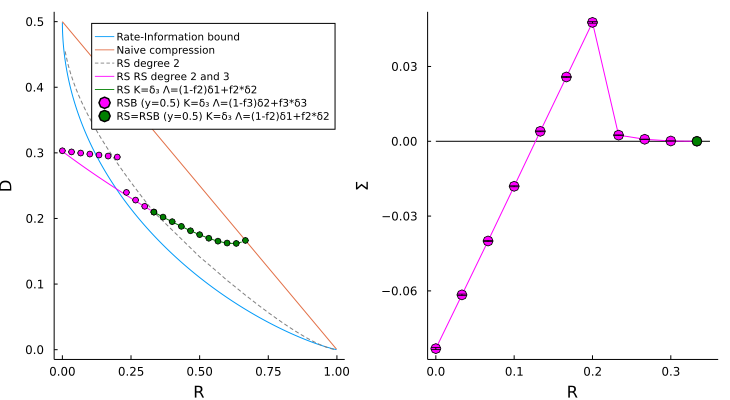

In [41]:
Plots.gr(grid=false)

p61 = plot_rdb(; f3=true)
plot!(p61, R12, D12, label="RS K=δ₃ Λ=(1-f2)δ1+f2*δ2", lc=:green)
scatter!(p61, Rs_rsb_23, Ds_rsb_23, yerr=Ds_er_rsb_23, label="RSB (y=0.5) K=δ₃ Λ=(1-f3)δ2+f3*δ3",m=:o, color="magenta")
scatter!(p61, Rs_rsb_12, Ds_rsb_12, yerr=Ds_er_rsb_12, label="RS=RSB (y=0.5) K=δ₃ Λ=(1-f2)δ1+f2*δ2",m=:o, color="green")
#plot(p61, size=(700,400), legend=:outertopright, legendfontsize=8)
plot(p61, size=(500,500), legendfontsize=7)

p62 = plot(0:0.001:0.35, zero(0:0.001:0.35), label=false, color="black")
plot!(p62, Rs_rsb_23, Σs_rsb_23, xlabel="R", ylabel="Σ", size=(300,300), yerr=Σs_er_rsb_23, ms=5, m=:o, color="magenta", label=false)
scatter!(p62, Rs_rsb_23[end:end], Σs_rsb_23[end:end], ms=5, color="green", label=false)

p6 = plot(p61, p62, size=(730,400))

In [42]:
savefig(p6, "cavity-predictions-deg123-y0p5.pdf")

In [43]:
avg_pops = readdlm("avg_pops.txt")

3×41 Matrix{Float64}:
 0.331915      0.109623     0.0374817     …  0.109546      0.331876
 4.66713e-87   2.39119e-75  6.75449e-65      6.72471e-74   3.53321e-86
 2.82136e-253  1.2153e-206  3.34313e-173     1.07977e-200  2.11163e-238

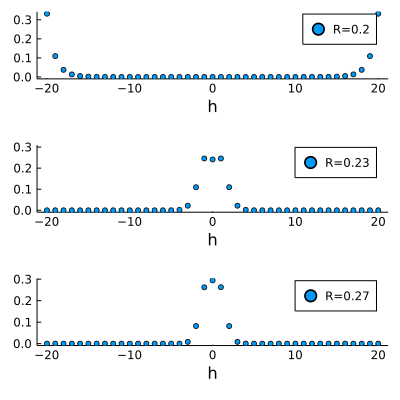

In [44]:
J = 20
Rs_avg_pops = [0.19999999999999984, 0.2333333333333334, 0.2666666666666666]

pa1 = scatter(-J:J, avg_pops[1,:], xlabel="h", label="R=0.2")
pa2 = scatter(-J:J, avg_pops[2,:], xlabel="h", yrange=[0.0,0.3], label="R=0.23")
pa3 = scatter(-J:J, avg_pops[3,:], xlabel="h", label="R=0.27")
pa = plot(pa1, pa2, pa3, size=(400,400), layout = (3, 1))

In [45]:
savefig(pa, "cavity-avg-distributions-deg23-y0p5.pdf")

## 6.2 Results with optimal $y$ 

In [46]:
# RS results for mix of deg 1 and 2 variables
R12, D12 = ([0.3333333333333333, 0.35333333333333333, 0.37333333333333335, 0.3933333333333333, 0.41333333333333333, 0.43333333333333335, 0.4533333333333333, 0.47333333333333333, 0.49333333333333335, 0.5133333333333333, 0.5333333333333333, 0.5533333333333333, 0.5733333333333334, 0.5933333333333334, 0.6133333333333333, 0.6333333333333333, 0.6533333333333333], [0.20962056095628745, 0.20510675972527204, 0.2006681095706887, 0.1963150986467942, 0.19206044986217263, 0.18791975969258612, 0.18391237135471517, 0.18006258976893397, 0.17640140622720218, 0.17296900253649872, 0.16981848174327074, 0.16702159326400678, 0.1646778261813926, 0.16292944871509907, 0.16198761138123774, 0.16218037482422176, 0.1640476353615466])
#RSB results: with J=20, y=0.5, popsize=10^6, maxiter=2*10^3, samples=10^8
# RSB results for mix of deg 1 and 2 variables, at y=0.5
Rs_rsb_12, Ds_rsb_12, Ds_er_rsb_12 = ([0.6666666666666667, 0.6333333333333333, 0.5999999999999999, 0.5666666666666667, 0.5333333333333334, 0.5, 0.4666666666666667, 0.43333333333333335, 0.4, 0.3666666666666667, 0.33333333333333337], [0.16650789649221948, 0.1619545698930388, 0.16254724608761323, 0.16540297668402337, 0.16983330668483132, 0.17531828954432616, 0.18126193781344913, 0.18797821686621807, 0.19515535726021943, 0.20209784064401598, 0.20965424141256622], [0.0003119215398973763, 0.00027977043094751036, 0.00029872535597937424, 0.00036559228419771243, 0.0003166580587697831, 0.0004597198308554774, 0.00031230872288686465, 0.00036419831799057846, 0.00044620878219726824, 0.00031767804611598603, 0.0005155641070213254])
# RS results for mix of deg 2 and 3 variables
R23 = [0.33333333333333337,0.33000000000000007,0.32666666666666666,0.32333333333333336,0.31999999999999995,0.31666666666666676,0.31333333333333335,0.31000000000000005,0.30666666666666664,0.30333333333333334,0.29999999999999993,0.29666666666666675,0.29333333333333333,0.29000000000000004,0.2866666666666666,0.2833333333333333,0.2799999999999999,0.2766666666666667,0.2733333333333333,0.2699999999999999,0.2666666666666666,0.2633333333333333,0.2599999999999999,0.2566666666666667,0.2533333333333333,0.25,0.2466666666666667,0.2433333333333333,0.23999999999999988,0.2366666666666667,0.2333333333333334,0.2300000000000001,0.22666666666666668,0.22333333333333327,0.22000000000000008,0.21666666666666679,0.21333333333333326,0.20999999999999996,0.20666666666666667,0.20333333333333348,0.19999999999999984,0.19666666666666666,0.19333333333333336,0.18999999999999995,0.18666666666666654,0.18333333333333324,0.18000000000000005,0.17666666666666675,0.17333333333333334,0.16999999999999993,0.16666666666666663,0.16333333333333344,0.16000000000000003,0.15666666666666662,0.15333333333333332,0.15000000000000002,0.1466666666666666,0.1433333333333332,0.14,0.13666666666666671,0.13333333333333341,0.1299999999999999,0.1266666666666666,0.1233333333333334,0.1200000000000001,0.11666666666666659,0.11333333333333329,0.10999999999999999,0.1066666666666668,0.10333333333333339,0.10000000000000009,0.09666666666666668,0.09333333333333327,0.08999999999999997,0.08666666666666678,0.08333333333333337,0.07999999999999996,0.07666666666666666,0.07333333333333336,0.06999999999999995,0.06666666666666654,0.06333333333333335,0.05999999999999994,0.05666666666666664,0.053333333333333344,0.050000000000000155,0.04666666666666652,0.043333333333333335,0.040000000000000036,0.036666666666666736,0.033333333333333215,0.029999999999999916,0.026666666666666727,0.023333333333333428,0.020000000000000018,0.01666666666666672,0.013333333333333308,0.009999999999999898,0.00666666666666671,0.0033333333333334103,0.0]
D23 = [0.20962056095628745,0.21045655312219785,0.21129398045076497,0.21213285191160997,0.21297317651789593,0.213814963331392,0.21465822146743357,0.21550296009981335,0.21634918846557782,0.2171969158697719,0.21804615169011754,0.2188969053816388,0.21974918648125297,0.22060300461230448,0.22145836948909192,0.22231529092135494,0.22317377881874867,0.22403384319531316,0.22489549417392346,0.22575874199075563,0.2266235969997512,0.22749006967709307,0.22835817062570685,0.22922791057977476,0.23009930040929016,0.23097235112463632,0.23184707388120812,0.23272347998408488,0.2336015808927387,0.23448138822581466,0.2353629137659588,0.23624616946472055,0.23713116744752138,0.23801792001870203,0.23890643966665281,0.2397967390690277,0.2406888310980555,0.24158272882594994,0.24247844553042286,0.2433759947003037,0.24427539004128584,0.24517664548178786,0.2460797751789402,0.24698479352472213,0.2478917151522217,0.248800554942059,0.2497113280289589,0.2506240498084894,0.2515387359439647,0.2524554023735355,0.25337406531746137,0.25429474128557106,0.25521744708493777,0.2561421998277597,0.2570690169394544,0.25799791616700474,0.2589289155875188,0.2598620336170625,0.26079728901973587,0.2617347009170402,0.26267428879751364,0.26361607252667024,0.2645600723572469,0.26550630893977045,0.2664548033334655,0.26740557701750556,0.26835865190263664,0.2693140503431725,0.2702717951493969,0.271231909600374,0.2721944174571924,0.27315934297666117,0.27412671092547497,0.2750965465948728,0.2760688758158149,0.2770437249746786,0.2780211210295341,0.27900109152699526,0.2799836646196798,0.28096886908431673,0.28195673434051494,0.28294729047022854,0.283940568237963,0.2849365991117401,0.2859354152848619,0.28693704969851397,0.28794153606524925,0.2889489088934002,0.28995920351242044,0.290972456099293,0.2919887037059378,0.2930079842877797,0.29403033673345685,0.2950558008957639,0.2960844176238681,0.29711622879689686,0.298151277358935,0.2991896073555008,0.30023126397162553,0.30127629357155217,0.30232474374018364];

In [47]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [48]:
Rs_morepoints = [0.3283333333333333, 0.31333333333333335, 0.29833333333333334, 0.2833333333333333]
Ds_morepoints = [0.2108590433752877, 0.21498216979510876, 0.2192732320989677, 0.22394452945477505]
Ds_er_morepoints = [0.00040544524643798205, 0.00040915890141348543, 0.00023874619959551126, 0.00018266315345967434];

┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873
┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873


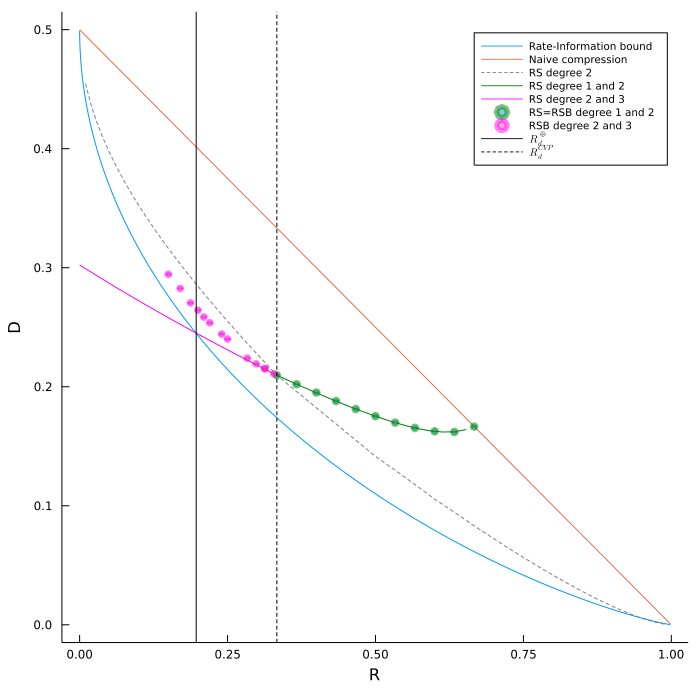

In [49]:
Plots.gr(grid=false)

p6b = plot_rdb(; f30=true, f3=false)
plot!(p6b, R12, D12, label="RS degree 1 and 2", lc=:green)
plot!(p6b, R23, D23, label="RS degree 2 and 3", lc=:magenta)
scatter!(p6b, Rs_rsb_12, Ds_rsb_12, yerr=Ds_er_rsb_12, label="RS=RSB degree 1 and 2",m=:o, msc=:green, markeralpha=0.5, msw=2)
scatter!(p6b, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="RSB degree 2 and 3", m=:à, msc=:magenta, markeralpha=0.5, msw=2)
scatter!(p6b, Rs_morepoints, Ds_morepoints, yerr=Ds_er_morepoints, m=:à, msc=:magenta, markeralpha=0.5, msw=2, label=false)
vline!(p6b, [0.197], label="\$ R_d^\\oplus \$", lc=:black)
vline!(p6b, [1/3], label="\$ R_d^{\\rm CVP} \$", lc=:black, ls=:dash)
plot(p6b, size=(700,700), legendfontsize=7)

## 6.2.b details around $R=1/3$

In [50]:
en_ct = readdlm("energetic_continuous_transition.txt")
#en_ct = (Rs, f3s, Ds, Ds_er, Fs, Fs_er, Σs, Σs_er)
Rs_ct = en_ct[1,:]
f3s_ct = en_ct[2,:]
Ds_ct = en_ct[3,:]
Ds_er_ct = en_ct[4,:]
Σs_ct = en_ct[7,:]
Σs_er_ct = en_ct[8,:];

┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873


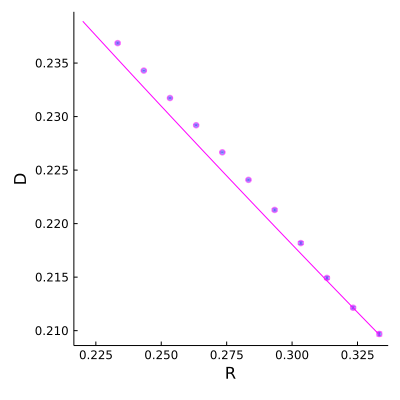

In [51]:
p62bD = scatter(Rs_ct, Ds_ct, yerr=Ds_er_ct, m=:à, msc=:magenta, markeralpha=0.5, msw=2, label=false, xlabel="R", ylabel="D")
plot!(p62bD, R23[1:35], D23[1:35], lc=:magenta, label=false)


┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873


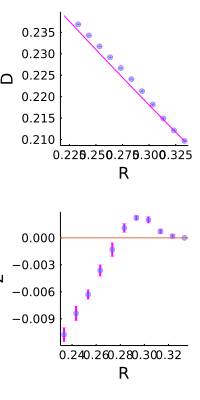

In [52]:
p62bΣ = scatter(Rs_ct, Σs_ct, yerr=Σs_er_ct, m=:à, msc=:magenta, markeralpha=0.5, msw=2, label=false, xlabel="R", ylabel="Σ")
hline!(p62bΣ, [0.0], label=false)
p62bDΣ = plot(p62bD, p62bΣ, size=(200,400), layout = (2, 1))

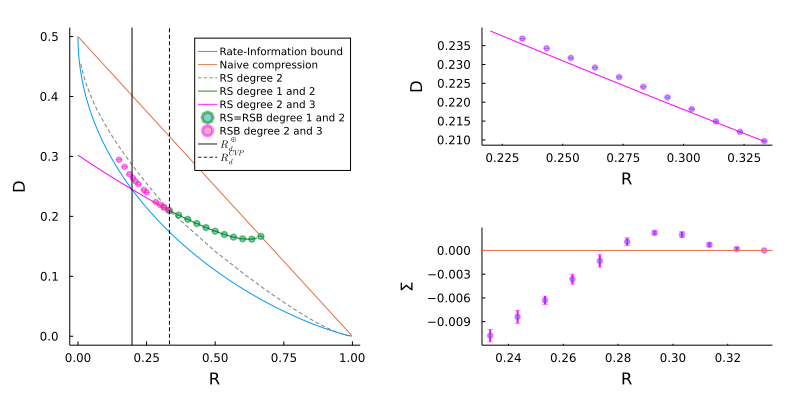

In [53]:
p6b_tot = plot(p6b, p62bDΣ, size=(800,400), layout = (1, 2), margin=5*Plots.mm, legendfontsize=7)

In [54]:
savefig(p6b_tot, "cavity-predictions-deg123-yopt.pdf")

## 6.3 y study

In [55]:
yopt_R17 = readdlm("yopt_R17.txt")
ys_R17 = yopt_R17[1,:]
Ds_R17 = yopt_R17[2,:]
Ds_er_R17 = yopt_R17[3,:]
Fs_R17 = yopt_R17[4,:]
Fs_er_R17 = yopt_R17[5,:]
Σs_R17 = yopt_R17[6,:]
Σs_er_R17 = yopt_R17[7,:]
avgpopPs_R17J = yopt_R17[8,:];
D_shannon_R17 = 0.26216

0.26216

In [56]:
p63_2a = scatter(ys_R17, Fs_R17, yerr=Fs_er_R17, label=false, xlabel="y", ylabel="F")
vline!(p63_2a, [0.46], color="red", label=false)
p63_2b = scatter(ys_R17, Ds_R17, yerr=Ds_er_R17, label=false, xlabel="y", ylabel="D")
hline!(p63_2b, [D_shannon_R17], label=false, color="black")
vline!(p63_2b, [0.46], color="red", label=false)
p63_2c = scatter(ys_R17, Σs_R17, yerr=Σs_er_R17, label=false, xlabel="y", ylabel="Σ")
hline!(p63_2c, [0.0], label=false, color="black")
vline!(p63_2c, [0.46], color="red", label=false)
p63_2d = scatter(ys_R17, avgpopPs_R17J, ylims=(-0.01, 0.5), label=false, xlabel="y", ylabel="\$ P_{\\rm avg}(J) \$")
vline!(p63_2d, [0.46], color="red", label=false)
p63_2 = plot(p63_2a, p63_2b, p63_2c, p63_2d, size=(1000,250), layout=(1,4));

In [57]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [58]:
Rs_rsb[8], y_rsb[8]

(0.17, 0.46)

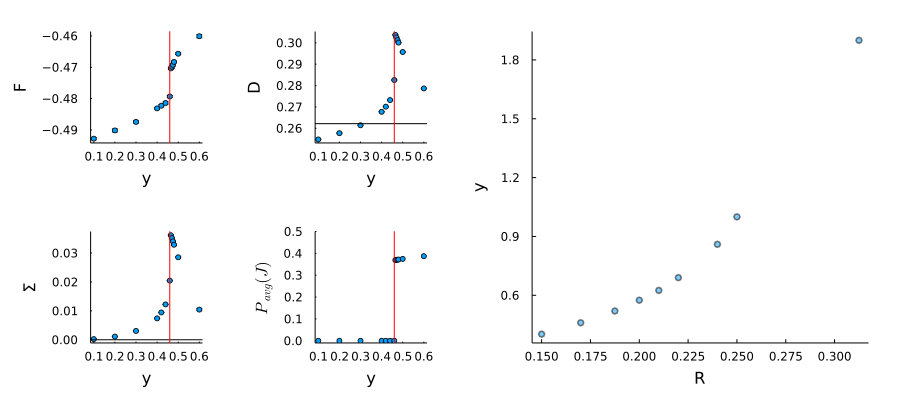

In [59]:
pyopt_1 = scatter(Rs_rsb[1:end-1], y_rsb[1:end-1],m=:o, msc=:black, markeralpha=0.5, msw=2, label=false, xlabel="R", ylabel="y")
pyopt_2 = plot(p63_2a, p63_2b, p63_2c, p63_2d, layout=(2,2))
pyopt = plot(pyopt_2, pyopt_1, size=(900,400), layout=(1,2), margin=6*Plots.mm, legendfontsize=7)

In [60]:
savefig(pyopt, "y_optimal.pdf")

# 7. Compare all with zero leaves

In [61]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

Comparison at f1=0


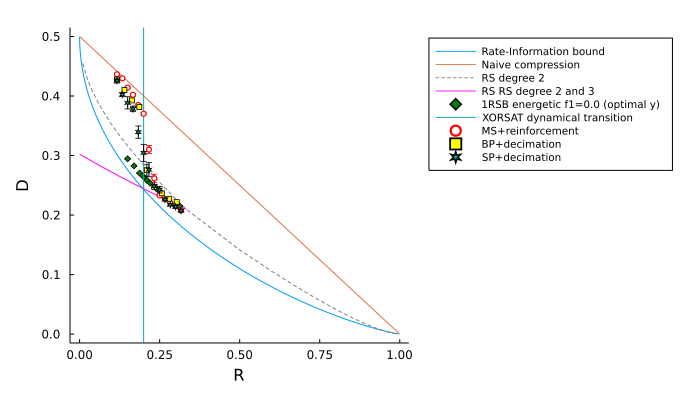

In [62]:
pl2 = plot_rdb(; f3=true)
scatter!(pl2, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="1RSB energetic f1=0.0 (optimal y)", 
    c=:green, m=:diamond)
vline!(pl2, [0.2], label="XORSAT dynamical transition")
scatter!(pl2, R_ms_0, D_ms_0_avg, label="MS+reinforcement", yerr=D_ms_0_std, 
    m=:circle, c=:white, msc=:red, msw=1.5)
#scatter!(pl2, Rs_rsb_23, Ds_rsb_23, yerr=Ds_er_rsb_23, label="1RSB prediction (y=0.5)", 
#    c=:magenta, m=:diamond)
scatter!(pl2, R_bp_dec, D_bp_dec_avg, label="BP+decimation", yerr=D_bp_dec_std, 
    m=:square, c=:yellow, ms=2.5)
scatter!(pl2, R_sp, D_sp_avg, yerr=D_sp_std, label="SP+decimation", m=:star6)
plot!(pl2, legend=:outertopright, size=(700,400), margin=5Plots.mm, legendfontsize=7)
println("Comparison at f1=0")
pl2

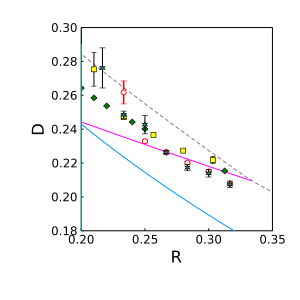

In [63]:
pl3 = deepcopy(pl2)
plot!(pl3, xlims=(0.2,0.35), ylims=(.18, .3), legend=false, size=(300,300), framestyle = :box)

# 8. Entropic results:

# 8.1: Dynamical threshold and distorsion at this threshold value

In [64]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [65]:
ent_tr = readdlm("entropic_transition.txt")
Rs_ent = ent_tr[1,:]
f3s_ent = ent_tr[2,:]
Hds_ent = ent_tr[3,:]
dist_ent = ent_tr[4,:]
std_dist_ent = ent_tr[5,:];

In [ ]:
p81a = scatter(Rs_ent, Hds_ent, xlabel="R", xrange=(0.16,0.33), ylabel="β", label="\$ \\beta_d \$", m=:à, msc=:blue, markeralpha=0.5, msw=2)
vline!(p81a, [0.197], label="\$ R_d^\\oplus \$", lc=:black)

p81b = plot_rdb(; f3=true)
scatter!(p81b, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="RSB degree 2 and 3", m=:à, msc=:magenta, markeralpha=0.5, msw=2)
vline!(p81b, [0.197], label="\$ R_d^\\oplus \$", lc=:black)
vline!(p81b, [1/3], label="\$ R_d^{\\rm CVP} \$", lc=:black, ls=:dash)
scatter!(p81b, Rs_ent, dist_ent, yerr=std_dist_ent, label="\$ \text{1RSB entropic} D(\\beta_d) \$", m=:à, msc=:blue, markeralpha=0.5, msw=2)

p81 = plot(p81a, p81b, size=(800,400), layout = (1, 2), margin=5*Plots.mm, legendfontsize=7)

## 8.2 More details at rate R=0.25

In [114]:
ent_details_R25 = readdlm("entropic_details_R25.txt")
Hs = ent_details_R25[1,:]
mean_q0s = ent_details_R25[2,:]
std_q0s = ent_details_R25[3,:]
mean_q1s = ent_details_R25[4,:]
std_q1s = ent_details_R25[5,:];
mean_Σs = ent_details_R25[12,:]
std_Σs = ent_details_R25[13,:];

In [115]:
Hs

14-element Vector{Float64}:
 0.0
 0.5
 1.0
 1.05
 1.1
 1.15
 1.2
 1.25
 1.3
 1.35
 1.4
 1.45
 1.5
 2.0

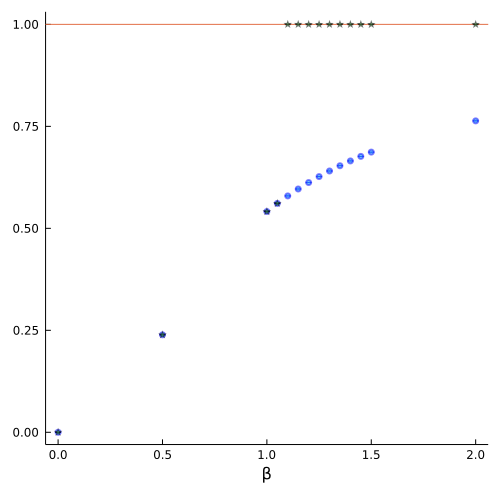

In [116]:
p82a = scatter(Hs, mean_q0s, yerr=std_q0s, xlabel="\$ \\beta \$", label="\$ q_0 \$", m=:dot, msc=:blue, msw=2, markeralpha=0.5)
hline!(p82a, [1.0], legend=false)
scatter!(p82a, Hs, mean_q1s, yerr=std_q1s, xlabel="\$ \\beta \$", label="\$ q_1 \$", m=:star, msw=1, markeralpha=0.5, size=(500,500))

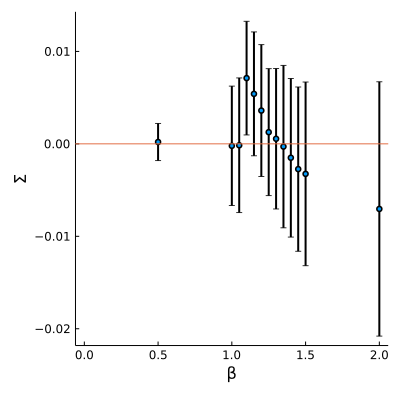

In [117]:
p82b = scatter(Hs, mean_Σs, yerr=std_Σs, xlabel="β", ylabel="Σ", m=:dot, msc=:black, msw=2)
hline!(p82b, [0.0], legend=false)

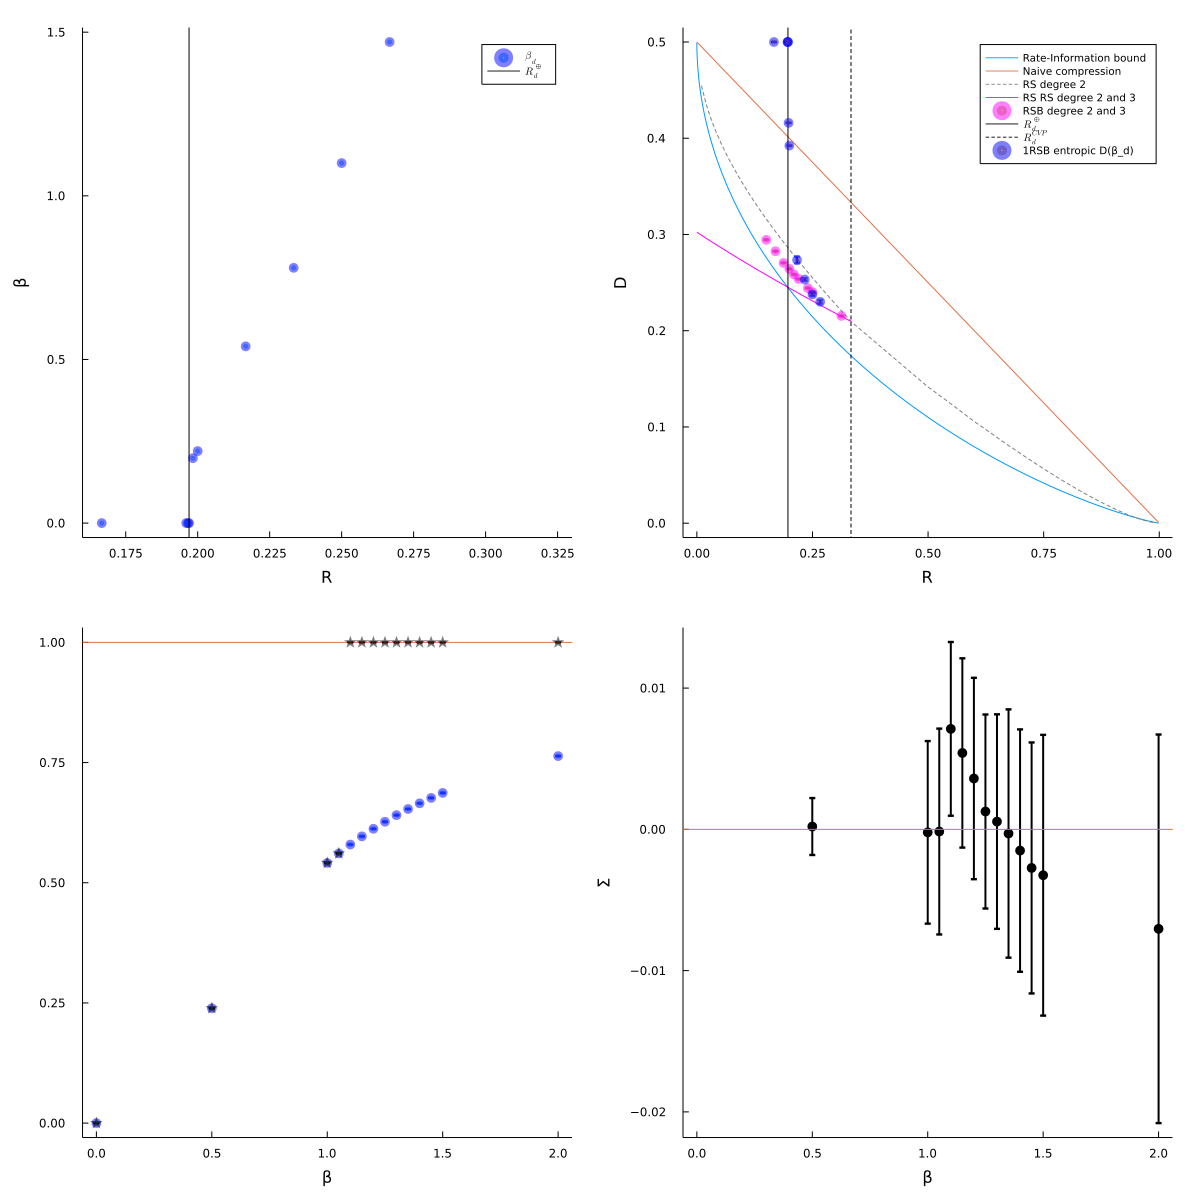

In [118]:
p8 = plot(p81a, p81b, p82a, p82b, size=(1200,1200), layout = (2, 2))

In [111]:
savefig(p8, "entropic-dyn-transition.pdf")

# 9. GF(q) maxsum

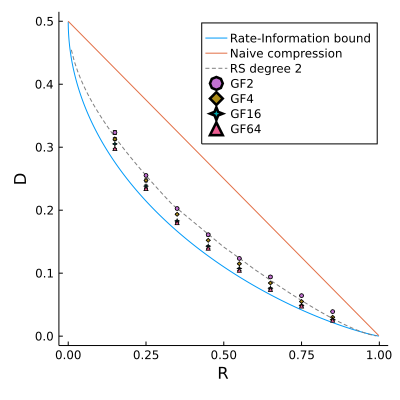

In [63]:
qs = [2, 4, 16, 64]
markers = [:o, :diamond, :star4, :^]
pl9 = plot_rdb()
for (i,q) in enumerate(qs)
    M = readdlm("gf$q.txt") 
    Rs = M[:,1]; d = M[:,2]; err = M[:,3]
    scatter!(pl9, Rs, d, yerr=err, marker=markers[i], label="GF$q", ms=2)
end
pl9

In [64]:
savefig("gfq_maxsum.pdf")

# 10. Exact enumeration

In [65]:
# cavity prediction for degree profile (0,f2,f3) for variables, (0,0,1) for factors
# obtained with energetic method at optimal y by maximizing the free energy
yopt_data = readdlm("yopt_data.txt")
Rs_rsb = yopt_data[1,:]
y_rsb = yopt_data[2,:]
Ds_rsb = yopt_data[3,:]
Ds_rsb_err = yopt_data[4,:];

In [66]:
M = readdlm("exact_enum.txt")

7×5 Matrix{Any}:
  "1//16"   "1//8"    "3//16"   "1//4"    "5//16"
 0.429717  0.373454  0.327732  0.288926  0.265648
 0.410505  0.349182  0.302486  0.26697   0.240826
 0.399165  0.335575  0.291708  0.257323  0.232722
 0.391786  0.328799  0.284856  0.252084  0.227717
 0.385505  0.323365  0.280937  0.24927   0.224882
 0.381359  0.320542  0.278204  0.247042  0.224221

In [67]:
Rs = 1//16:1//16:5//16
d_avg = [[0.42971737132352933, 0.37345359078590784, 0.32773159144893105, 0.28892645474137935, 0.2656481481481482],
 [0.41050535714285713, 0.3491819444444444, 0.3024856770833333, 0.26696950604838715, 0.24082620724346077],
 [0.39916504539559017, 0.33557471264367816, 0.2917079067121729, 0.2573234463276836, 0.2327224099099099],
 [0.39178618421052613, 0.3287986809045227, 0.284855527638191, 0.25208437499999997, 0.22771718749999997],
 [0.3855052631578948, 0.323365, 0.28093749999999995, 0.249270202020202, 0.22488249999999999],
 [0.38135850694444434, 0.3205416666666666, 0.27820416666666664, 0.24704166666666666, 0.22422083333333334]]
d_std = [[0.0008466764011882642, 0.0006413044388290522, 0.000583476794735974, 0.0005625947111551583, 0.0005302184845228426],
 [0.0006468108297888889, 0.0005132607712172563, 0.00044868841642856994, 0.0004167958226216948, 0.0003839697238247693],
 [0.0005097852317637724, 0.0003900336471630603, 0.00038175133796398454, 0.0003384549802564654, 0.00033629907206701243],
 [0.0004526622737919807, 0.00037324209171413366, 0.0003430536943300457, 0.0003176948091418133, 0.00030181316391108404],
 [0.0005149905541073803, 0.0003806463800782379, 0.00036326547531461805, 0.0003837102011227218, 0.00039189153763857597],
 [0.0005101591470300435, 0.00043963078458789643, 0.00041861322520069183, 0.0004036662341234759, 0.000540743915755234]]
qs = vec([0.37685682823489813
 0.312779814205261
 0.27028959645611467
 0.23983090157793577
 0.21545675908298528])
qs_err = vec( [0.0032938239660579858
 0.002367628983323577
 0.00149987985917356
 0.0009875133059880858
 0.0003476138463665261])
qs2 = vec([ 0.36250360408560883
 0.3023236248224275
 0.26368530855761135
 0.23547983266027256
 0.21489437047455573])
qs2_err = vec([ 0.0017343135595940236
 0.0006294772048813755
 0.0005131028060149212
 0.00032282946156977443
 0.0009093629315455092])
ns = [16, 32, 48, 64, 80, 96]
navg = [1000, 500, 300, 200, 100, 50]

6-element Vector{Int64}:
 1000
  500
  300
  200
  100
   50

┌ Warning: Skipped marker arg à.
└ @ Plots /home/louise/.julia/packages/Plots/vVVub/src/args.jl:873


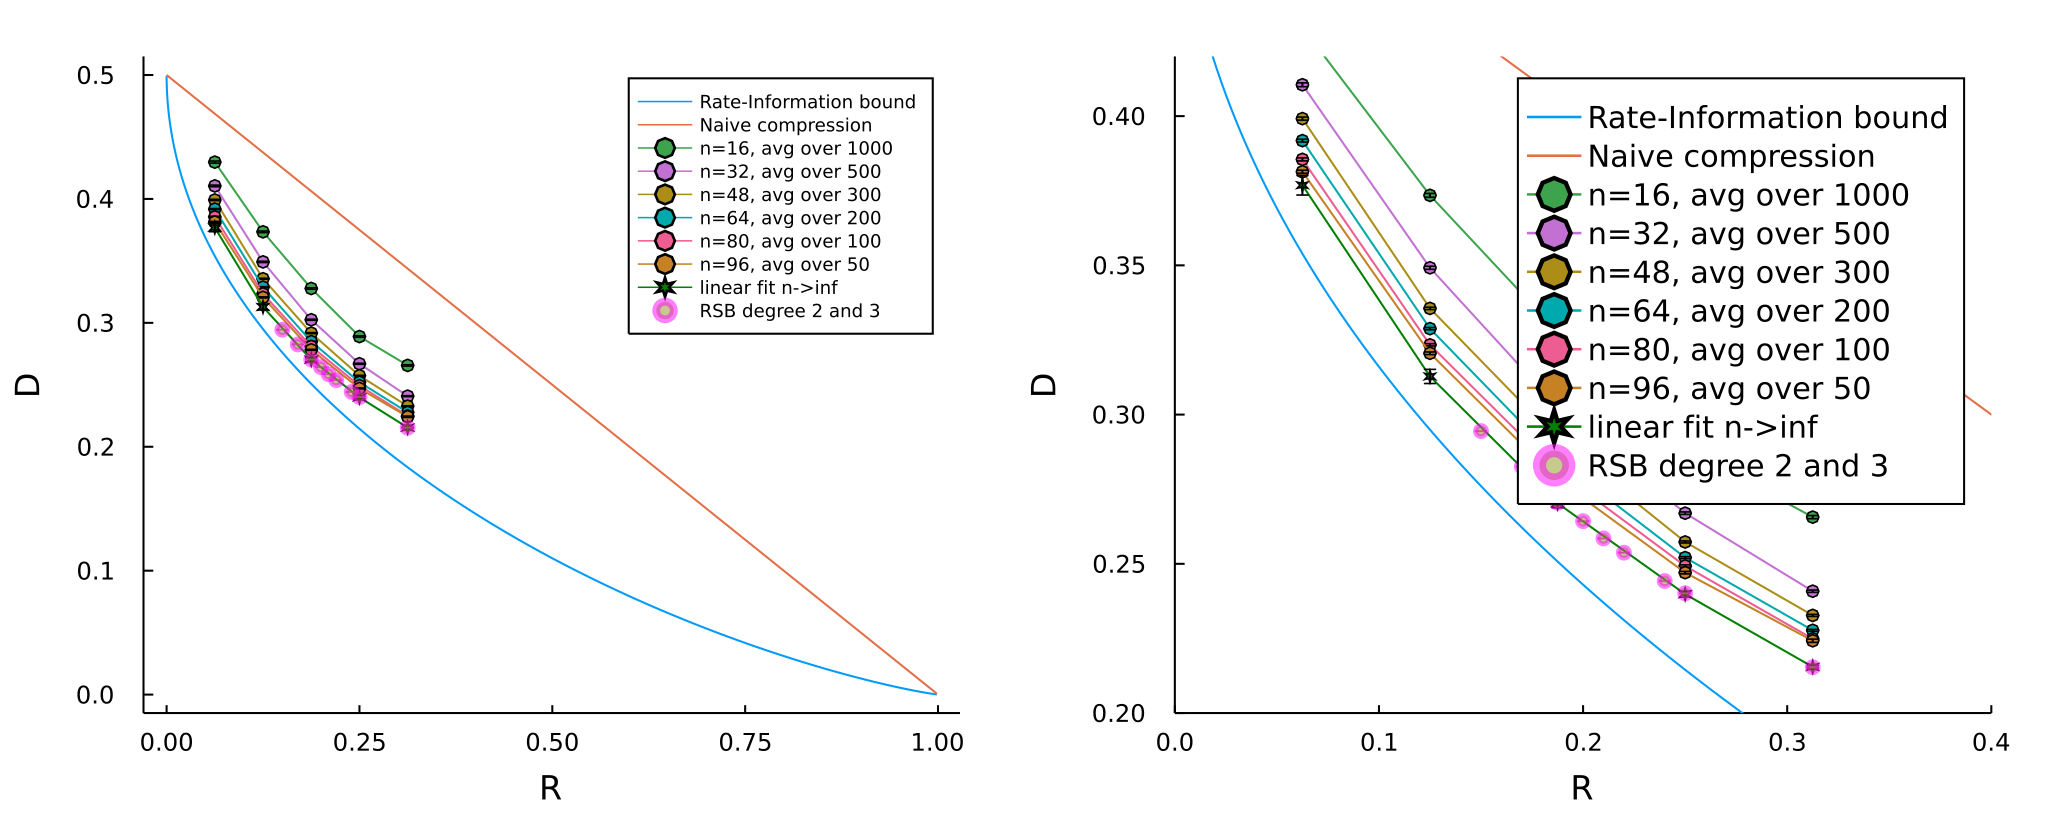

In [68]:
pl = plot_rdb(f3=false, f30=false)
for (i,n) in enumerate(ns)
    plot!(pl, Rs, d_avg[i], yerr=d_std[i], ms=3, label="n=$n, avg over $(navg[i])", marker=:o)
end
plot!(pl, Rs, qs, yerr=qs_err, ms=3, label="linear fit n->inf", marker=:star6, c=:green)
#plot!(pl, Rs, qs2, yerr=qs2_err, ms=3, label="quadratic fit n->inf", marker=:star8, c=:red)
M = readdlm("bp_dec_zeroleaves.txt")
R_bp_dec = M[:,1]
D_bp_dec_avg = M[:,2]
D_bp_dec_std = M[:,3]
plot!(pl, legendfontsize=6)
scatter!(pl, Rs_rsb[1:end-1], Ds_rsb[1:end-1], yerr=Ds_rsb_err[1:end-1], label="RSB degree 2 and 3", m=:à, msc=:magenta, markeralpha=0.5, msw=3)
pl2 = deepcopy(pl)
# plot!(pl2, Rs_rsb_23, Ds_rsb_23, m=:diamond, label="RSB y=0.5")
# scatter!(pl2, [0.24, 0.25], [0.2414, 0.2401], label="RSB", m=:diamond, msc=:brown, markeralpha=0.5, msw=2, c=:white)
plot!(pl2, xlims=(0, 0.4), ylims=(0.2, 0.42), legendfontsize=10)
# plot!(pl, R_bp_dec, D_bp_dec_avg, m=:x, label="BP+dec")
plot(pl, pl2, size=(1000,400), margin=5Plots.mm, dpi=1000)

In [69]:
savefig(pl2, "exact_enum.pdf")

In [70]:
using DataFrames, GLM
d_avg_ = reduce(hcat, d_avg)
qs = zeros(length(Rs))
qs2 = zeros(length(Rs))
ms = copy(qs)
qs_err = copy(qs)
qs2_err = copy(qs)
ns_inv = 1 ./ ns
plts = Plots.Plot[]
for i in eachindex(qs)
    x = ns_inv
    x_range = LinRange(0, maximum(x), 100)
    y = d_avg_[i,:]
    data = DataFrame(X=x, Y=y)
    ols = lm(@formula(Y ~ X), data)
    qs[i], ms[i] = coef(ols)
    qs_err[i] = stderror(ols)[1]
    ols2 = lm(@formula(Y ~ X + X^2), data)
    qs2[i], b, c = coef(ols2)
    qs2_err[i] = stderror(ols2)[1]
    plt = scatter(x, y, xlabel="1/n", ylabel="d", label="")
    plot!(plt, x_range, x_range*ms[i] .+ qs[i], title="R=$(float(Rs[i]))", titlefontsize=9, label="linear", 
        legend=:bottomright, c=:green)
    scatter!(plt, [0], [qs[i]], yerr=[qs_err[i]], c=:green, label="", m=:star6)
    plot!(plt, x_range, x_range.^2*c .+ x_range*b .+ qs2[i], title="R=$(float(Rs[i]))", titlefontsize=9, 
        label="quadratic", c=:red)
    scatter!(plt, [0], [qs2[i]], yerr=[qs2_err[i]], c=:red, label="", m=:star8, labelfontsize=9)
    push!(plts, plt)
end
plot(plts..., size=(900,400), margin=5Plots.mm)

LoadError: ArgumentError: Package GLM not found in current path:
- Run `import Pkg; Pkg.add("GLM")` to install the GLM package.
